# Homework 7. IASA NLP Course

Made by Andrii Shevtsov

## Imports and constants

In [1]:
!pip install --upgrade umap-learn bertopic python-dotenv openai==0.28 langchain

In [40]:
import os

import re
import io
import string
import random

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openai

from collections import defaultdict 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.base import ClusterMixin, BaseEstimator
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from umap import UMAP
from bertopic import BERTopic
from transformers import pipeline
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import OpenAI
from dotenv import load_dotenv

random.seed(155)
np.random.seed(155)
pd.set_option('display.max_colwidth', None)
load_dotenv()

True

In [41]:
INPUT_TEXTS_FILE = "./data/KyivChannels_Dataset_v01.csv"

UKRAINIAN_STOPWORDS_FILE = "./data/stopwords_ua.txt"
TOPICS_FILE = "./data/topics.txt"

In [42]:
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load and preprocess data

In [5]:
df = pd.read_csv(INPUT_TEXTS_FILE)

In [6]:
df.head()

,channelname,Date,content,lang
0,kyivpolitics,2023-08-01 09:45:38,Отбой. Угрозы для столицы нет\n\nКиев. Главное. Политика,ru
1,kyivpolitics,2023-08-01 10:03:38,На 8 перекрестках Киева в пилотном режиме внедрят смежную светофорную регулировку пешеходов и велосипедистов\n\nНа этих перекрестках до 1 ноября 2023 будут использоваться измененные линзы пешеходных светофоров с изображением пешехода и велосипеда.\n\nСписок перекрестков на фото.\n\nКиев. Главное. Политика,ru
2,kyivpolitics,2023-08-01 14:42:31,⚡️НБУ отозвал банковскую лицензию Конкорд Банка за нарушение в сфере денежного мониторинга\n\nРанее он фигурировал в расследованиях по мискодингу и махинациям игорного бизнеса. Вывод его с рынка не повлияет на стабильность банковского сектора Украины. Каждый вкладчик банка получит полное возмещение.\n\nКиев. Главное. Политика,ru
3,kyivpolitics,2023-08-01 15:37:34,Завтра синоптики прогнозируют небольшой дождь с грозами\n\nКиев. Главное. Политика,ru
4,kyivpolitics,2023-08-01 13:06:08,А вот и сам снятый советский герб \n\nКиев. Главное. Политика,ru


Using basic functions from the lecture to clean texts

In [7]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = re.sub(r"@\S+", "", input) # Telegram entities deletion
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        input = input.lower()
    return input

df["content_processed"] = df["content"].apply(process_text)

In [8]:
def read_txt_to_list(path, encoding="utf-8"):
    with io.open(path, mode="r", encoding=encoding) as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list(UKRAINIAN_STOPWORDS_FILE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


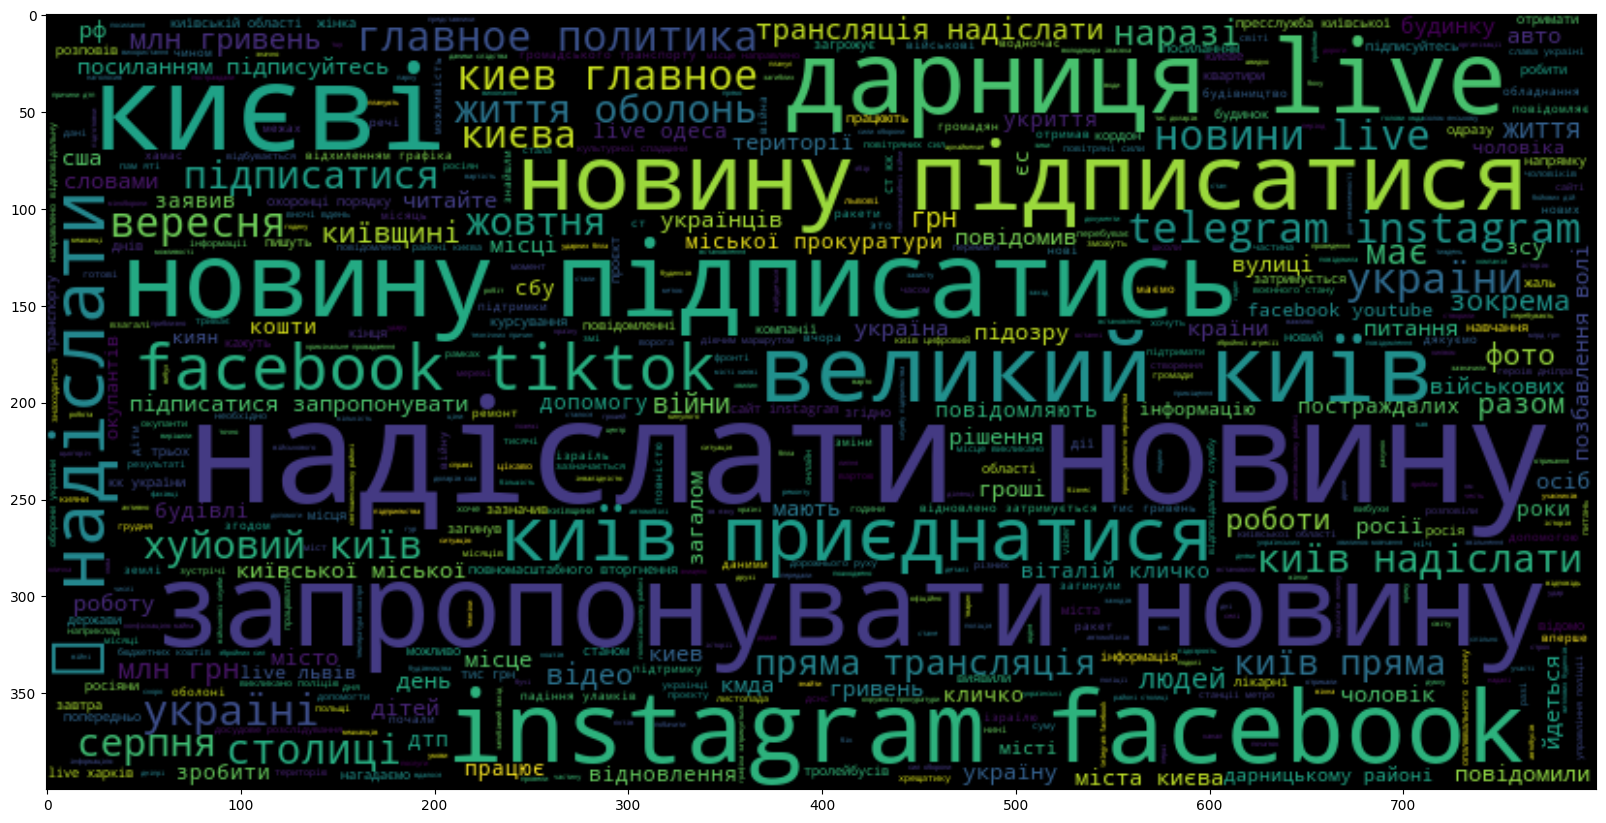

In [9]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

Based on several iterations, I created additional stopwords list:

In [10]:
additional_stopwords = [
    # slogans
    "надіслати", "новину", "запропонувати", "приєднатися", "підписатися", "підписатись", "пряма", "трансляція", "читайте", "посиланням", "підписуйтесь",
    # Kyiv and Ukraine variations
    "Київ", "міста", "Києва", "українців", "великий", "Дарницькому районі", "Київщині", "столиці", "Україна", "Києві", "Киев", "України", "Україні", "оболонь", "дарницькому", "Україну",
    # channel names
    "дарниця", "livе", "hmarochos", "хуйовий", "главное", "политика", "novosti_kieva_bot", "киев", "главное", "життя оболонь", "los", "solomas", "новини live", "новини", "live", "життя",
    # social networks
    "telegram", "instagram", "facebook", "tiktok", "youtube", "twitter",
    # untracked real stopwords
    "наразі", "зокрема", "загалом", "млн", "має","грн",
    # months
    "вересня", "жовтня", "серпня",
    # toponimics
    "вул", "район", "районі"
]

> **TODO**: use some regexps to decrease number of additional stopwords

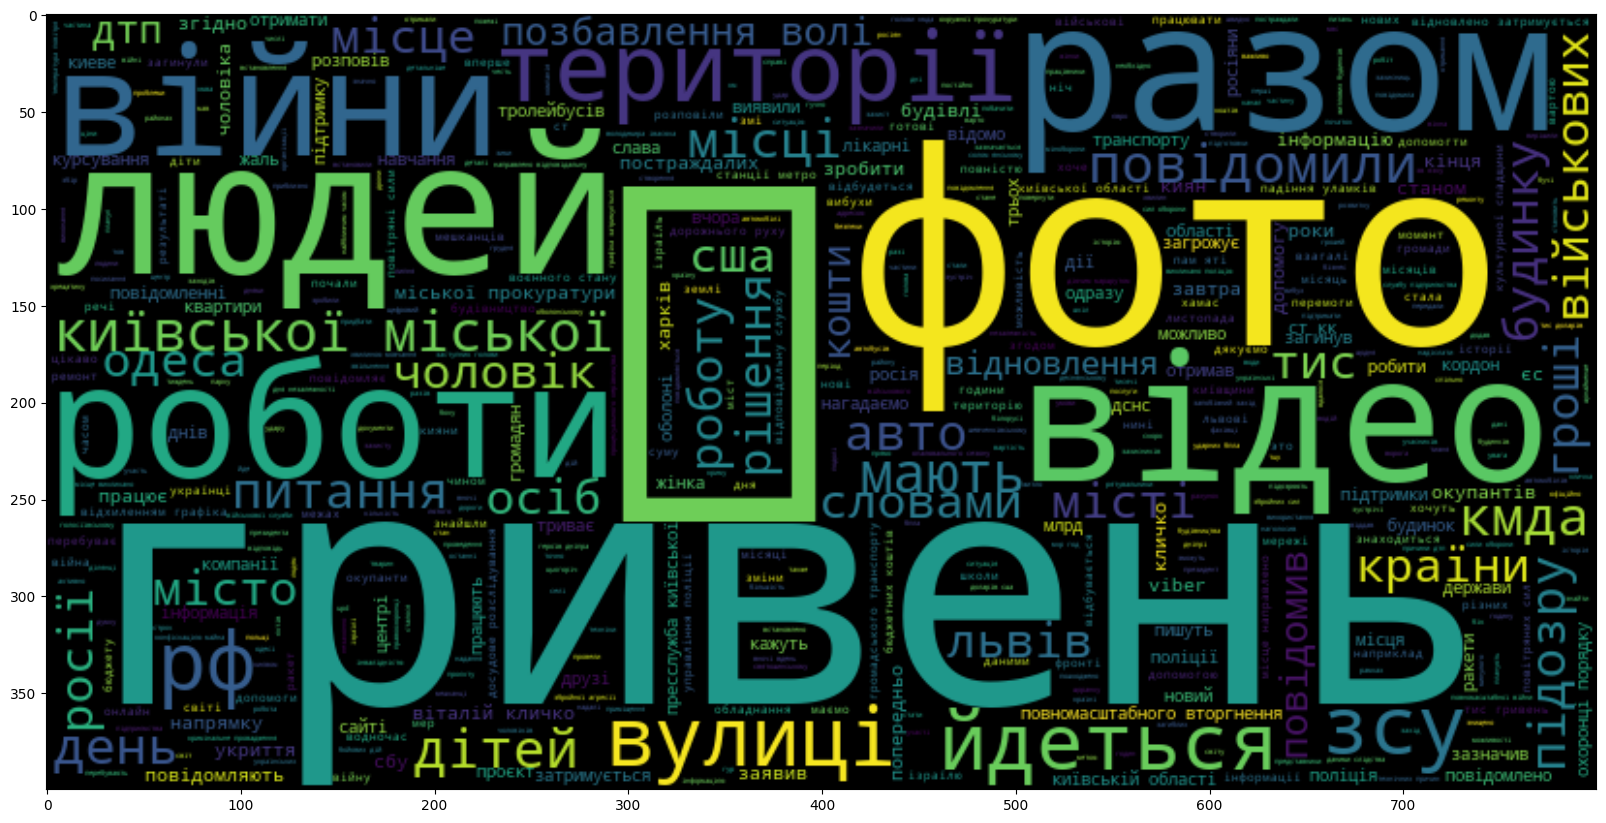

In [11]:
plt.figure(figsize = (20,20)) 
wc2 = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400,
    stopwords = [word.lower() for word in ru_stopwords + ua_stopwords + additional_stopwords])\
    .generate(" ".join(df["content_processed"]))
plt.imshow(wc2, interpolation = 'bilinear')
plt.show()

In [12]:
stopwords_set = set([word.lower() for word in ru_stopwords + ua_stopwords + additional_stopwords])

df["content_processed_without_stopwords"] = df["content_processed"].apply(wc2.process_text)
df["content_processed"] = df["content_processed"].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords_set]))

## Part 1. Analyze specific channels

In [13]:
all_channels = df['channelname'].unique()
chosen_channels = np.random.choice(all_channels, 3)
chosen_channels

array(['kyivcityofficial', 'tsum6', 'lisovy_masyv_official'], dtype=object)

In [14]:
# chosen_channels = np.array(['kyivcityofficial', 'tsum6', 'lisovy_masyv_official'])

In [15]:
df_chosen = df[df['channelname'].isin(chosen_channels)]
df_chosen.head()

,channelname,Date,content,lang,content_processed,content_processed_without_stopwords
27,lisovy_masyv_official,2023-08-01 16:06:57,"Зараз в нічному небі столиці можна спостерігати «осетровий супермісяць»\n\nНаш супутник виглядає більшим та яскравішим, адже опинився на відстані 357 530 км від Землі (зазвичай Місяць знаходиться на відстані з 384 400 км від планети).\n\n«Осетровим» його прозвали на честь найбільшої риби Північної Америки, якої багато водиться в цей період у тамтешніх озерах.\n\nПідписатися | Запропонувати новину",uk,"нічному небі спостерігати «осетровий супермісяць». супутник виглядає більшим яскравішим, опинився відстані 357 530 км землі (зазвичай місяць знаходиться відстані 384 400 км планети). «осетровим» прозвали честь найбільшої риби північної америки, водиться період тамтешніх озерах. |","{'нічному': 1, 'небі': 1, 'спостерігати': 1, 'осетровий': 1, 'супермісяць': 1, 'супутник': 1, 'виглядає': 1, 'більшим': 1, 'яскравішим': 1, 'опинився': 1, 'відстані': 2, 'км': 2, 'землі': 1, 'місяць': 1, 'знаходиться': 1, 'планети': 1, 'осетровим': 1, 'прозвали': 1, 'честь': 1, 'найбільшої': 1, 'риби': 1, 'північної': 1, 'америки': 1, 'водиться': 1, 'період': 1, 'тамтешніх': 1, 'озерах': 1}"
28,lisovy_masyv_official,2023-08-01 03:00:09,"Щоранку о 09:00 вся Україна завмирає - у цю мить, ми вшановуємо пам'ять загиблих у війні хвилиною мовчання\n\nПідписатися | Запропонувати новину",uk,"щоранку 09:00 завмирає - мить, вшановуємо пам'ять загиблих війні хвилиною мовчання. |","{'щоранку': 1, 'завмирає': 1, 'мить': 1, 'вшановуємо': 1, 'пам'ять': 1, 'загиблих': 1, 'війні': 1, 'хвилиною': 1, 'мовчання': 1}"
29,lisovy_masyv_official,2023-08-01 14:02:05,"⚠️ Повідомляють про повітряну ціль, можливо фальш ціль на Чернігівщині\n\nПідписатися | Запропонувати новину",uk,"⚠️ повідомляють повітряну ціль, можливо фальш ціль чернігівщині. |","{'повідомляють': 1, 'повітряну': 1, 'ціль': 2, 'можливо': 1, 'фальш': 1, 'чернігівщині': 1}"
30,lisovy_masyv_official,2023-08-01 20:45:31,"⚠️ Попередьо, фіксуються додаткові шахеди з північного напрямку на столицю.\n\nПідписатися | Запропонувати новину",uk,"⚠️ попередьо, фіксуються додаткові шахеди північного напрямку столицю. |","{'попередьо': 1, 'фіксуються': 1, 'додаткові': 1, 'шахеди': 1, 'північного': 1, 'напрямку': 1, 'столицю': 1}"
33,lisovy_masyv_official,2023-08-01 10:09:25,"Столичні поліцейські розпочали кримінальне провадження за фактом діяльності call-центру у Подільському районі \n\nВ офісному приміщенні правоохоронці виявили 220 робочих місць, оснащених комп’ютерною технікою. З місця події вилучено системні блоки, жорсткі диски, мобільні телефони та робочі блокноти. Крім того, було знайдено печатки російських компаній та банків. \n\nУ приміщенні самого офісу знаходилося 47 осіб, поліцейські ідентифікували кожного та виявили серед них двох іноземців. Наразі тривають заходи із встановлення їх причетності до співпраці із країною-агресором та організаторів так званого call-центру.\n\nПідписатися | Запропонувати новину",uk,"столичні поліцейські розпочали кримінальне провадження фактом діяльності call-центру подільському . офісному приміщенні правоохоронці виявили 220 робочих місць, оснащених комп’ютерною технікою. місця події вилучено системні блоки, жорсткі диски, мобільні телефони робочі блокноти. того, знайдено печатки російських компаній банків. приміщенні офісу знаходилося 47 осіб, поліцейські ідентифікували виявили іноземців. тривають заходи встановлення причетності співпраці країною-агресором організаторів званого call-центру. |","{'столичні': 1, 'поліцейські': 2, 'розпочали': 1, 'кримінальне': 1, 'провадження': 1, 'фактом': 1, 'діяльності': 1, 'call': 2, 'центру': 2, 'подільському': 1, 'офісному': 1, 'приміщенні': 2, 'правоохоронці': 1, 'виявили': 2, 'робочих': 1, 'місць': 1, 'оснащених': 1, 'комп': 1, 'ютерною': 1, 'технікою': 1, 'місця': 1, 'події': 1, 'вилучено': 1, 'системні': 1, 'блоки': 1, 'жорсткі': 1, 'диски': 1, 'мобільні': 1, 'телефони': 1, 'робочі': 1, 'блокноти': 1, 'знайдено':

In [16]:
df_chosen['channelname'].value_counts()

channelname
lisovy_masyv_official    722
kyivcityofficial         247
tsum6                     51
Name: count, dtype: int64

### Clustering approaches

The most obvious approach is just to choose all the frequent words for the channel, cluster them and return clusters' most representative words.

Let's try it for the most popular channel in my list:

In [17]:
most_popular = df_chosen['channelname'].value_counts().keys()[0]
most_popular

'lisovy_masyv_official'

In [18]:
df_most_popular = df_chosen[df_chosen['channelname'] == most_popular]

In [19]:
df_most_popular["content_processed_without_stopwords"]

27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        {'нічному': 1, 'небі': 1, 'спостерігати': 1, 'осетровий': 1, 'супермісяць': 1, 'супутник': 1, 'виглядає': 1, 'більшим': 1, 'яскравішим': 1, 'опинився': 1, 'відстані': 2, 'км': 2, 'землі': 1, 'місяць': 1, 'знаходиться': 1, 'планети': 1, 'осетровим': 1, 'прозвали': 1, 'честь': 1, 'найбільшої': 1, 'риби': 1, 'північної': 1, 'америки': 1, 'водиться': 1, 'період': 1, 'тамтешніх': 1, 'озерах': 1}
28  

In [20]:
most_popular_ch_words_counts = defaultdict(lambda: 0)
for post_words_counts in df_most_popular["content_processed_without_stopwords"]:
    for word, count in post_words_counts.items():
        most_popular_ch_words_counts[word] += count

In [21]:
sorted(most_popular_ch_words_counts.items(), reverse=True, key=lambda el: el[1])[:20]

[('загиблих', 67),
 ('війні', 65),
 ("пам'ять", 63),
 ('вшановуємо', 60),
 ('мовчання', 60),
 ('щоранку', 59),
 ('завмирає', 59),
 ('мить', 59),
 ('хвилиною', 59),
 ('лісовий', 53),
 ('кубанської', 43),
 ('роботи', 42),
 ('поліції', 41),
 ('вулиці', 40),
 ('поліція', 35),
 ('лісовому', 33),
 ('деснянському', 33),
 ('кмда', 33),
 ('чоловіка', 33),
 ('людей', 32)]

In [22]:
TOP_P = 0.05

In [23]:
top_words = sorted(most_popular_ch_words_counts.items(), reverse=True, key=lambda el: el[1])

top_words = top_words[:int(TOP_P*len(top_words))]
top_words, _ = zip(*top_words)
top_words[:10]

('загиблих',
 'війні',
 "пам'ять",
 'вшановуємо',
 'мовчання',
 'щоранку',
 'завмирає',
 'мить',
 'хвилиною',
 'лісовий')

In [24]:
sent_emb_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2", device="cuda",)

In [25]:
top_words_embeddings = sent_emb_model.encode(top_words, batch_size=100)

In [26]:
top_words_embeddings.shape

(420, 512)

In [27]:
kmeans_clusts_top_words = KMeans(
    n_clusters=10, 
    random_state=155, 
    init="k-means++",
    n_init='auto'
).fit_predict(top_words_embeddings)

In [28]:
top_words_embeddings.shape

(420, 512)

In [29]:
top_words_embeddings[kmeans_clusts_top_words == 0].shape

(5, 512)

In [30]:
topics = []
for cluster_i in np.unique(kmeans_clusts_top_words):
    words = [top_words[i] for i in range(len(top_words)) if kmeans_clusts_top_words[i] == cluster_i]
    embs = top_words_embeddings[kmeans_clusts_top_words == cluster_i]
    
    centroid = np.mean(embs, axis=0)
    lengths = np.linalg.norm(embs - centroid, axis=1)
    min_indices = np.argsort(lengths)
    
    topics.append([words[min_indices[i]] for i in range(min(3, len(words)))])
    
topics

[['слідства', 'розслідування', 'перевірки'],
 ['кількість', 'троєщина', 'десяти'],
 ['проведення', 'заходів', 'станом'],
 ['мешканців', 'осіб', 'володимир'],
 ['району', 'районів', 'територію'],
 ['вдень', 'дня', 'днів'],
 ['ракет', 'ракети'],
 ['допомога', 'допомогу', 'допомогти'],
 ['зазначив', 'волі', 'триває'],
 ['гривень', 'щеплення', 'підльоту']]

We can see here, that some lists of words can tell us something while others can't. Often, several several word versions are at the top list. And some themes look very strange, for example, `['гривень', 'щеплення', 'підльоту']`.

Still, let's make a function to create such topic lists and test many hyperparameters and approaches on three channels we have chosen:

In [31]:
def clustering_create_word_topics(
    channel_df: pd.DataFrame,
    clustering_algorithm: ClusterMixin,
    embedder: SentenceTransformer,
    dim_reductor: BaseEstimator = None,
    words_choosing_method: str = "top_p",
    top_p: float = 0.05,
    top_k: int = 100,
    count_bound: int = 10,
    words_topic_out: int = 3
):
    words_choosing_method = words_choosing_method.lower()
    assert words_choosing_method in {"top_p", "top_k", "count_bound", "none"}, "Words choosing method should be one of these"
    
    ch_words_counts = defaultdict(lambda: 0)
    for post_words_counts in channel_df["content_processed_without_stopwords"]:
        for word, count in post_words_counts.items():
            ch_words_counts[word] += count
    
    top_words = sorted(ch_words_counts.items(), reverse=True, key=lambda el: el[1])
    
    if words_choosing_method == 'top_p':
        top_words = top_words[:int(top_p*len(top_words))]
    elif words_choosing_method == 'top_k':
        top_words = top_words[:min(top_k, len(top_words))]
    elif words_choosing_method == 'count_bound':
        _, top_words_counts = zip(*top_words)
        top_words_counts = np.array(top_words_counts)
        top_words = np.array(top_words)[top_words_counts >= count_bound]
    
    top_words, _ = zip(*top_words)
        
    top_words_embeddings = embedder.encode(top_words, batch_size=100)
    
    if dim_reductor:
        top_words_embeddings = dim_reductor.fit_transform(top_words_embeddings)
                
    clusts_top_words = clustering_algorithm.fit_predict(top_words_embeddings)
    
    # if len(clusts_top_words.shape) == 2:
    #     clusts_top_words = np.argmax(clusts_top_words, axis=1)
        
    topics = []
    for cluster_i in np.unique(clusts_top_words):
        if cluster_i < 0: # skipping outliers
            continue
        
        words = [top_words[i] for i in range(len(top_words)) if clusts_top_words[i] == cluster_i]
        embs = top_words_embeddings[clusts_top_words == cluster_i]

        centroid = np.mean(embs, axis=0)
        lengths = np.linalg.norm(embs - centroid, axis=1)
            
        min_indices = np.argsort(lengths)

        topics.append('-'.join([words[min_indices[i]] for i in range(min(words_topic_out, len(words)))]))

    return topics

In [32]:
channel_dfs = [df_chosen[df_chosen['channelname'] == channel_name] for channel_name in chosen_channels]

sets_to_test = {
    'KMeans 5 clusters, no dim reduction, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'KMeans 5 clusters, no dim reduction, top 1000 words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_k',
        'top_k': 1000
    },
    'KMeans 5 clusters, no dim reduction, words with 5+ occurences': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'count_bound',
        'count_bound': 5
    },
    'KMeans 5 clusters, no dim reduction, all words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'none'
    },
    'KMeans 5 clusters, PCA 64 components, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'dim_reductor': PCA(n_components=64, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'KMeans 5 clusters, t-SNE 3 components, top 5% words': {
        'clustering_algorithm': KMeans(
            n_clusters=5, 
            random_state=155, 
            init="k-means++",
            n_init='auto'
        ),
        'embedder': sent_emb_model,
        'dim_reductor': TSNE(n_components=3, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 10, 2 min samples, t-SNE 3 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=10,
            min_samples=2
        ),
        'embedder': sent_emb_model,
        'dim_reductor': TSNE(n_components=3, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 4 min samples, no dim reduction, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=4
        ),
        'embedder': sent_emb_model,
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 4 min samples, PCA 64 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=4
        ),
        'embedder': sent_emb_model,
        'dim_reductor': PCA(n_components=64, random_state=155),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'DBSCAN eps 0.2, 5 min samples, UMAP 4 components, top 5% words': {
        'clustering_algorithm': DBSCAN(    
            eps=0.2,
            min_samples=5
        ),
        'embedder': sent_emb_model,
        'dim_reductor': UMAP(n_components=4, n_neighbors=15),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
    'HDBSCAN min cluster size 5, UMAP 4 components, top 5% words': {
        'clustering_algorithm': HDBSCAN(    
            min_cluster_size=10
        ),
        'embedder': sent_emb_model,
        'dim_reductor': UMAP(n_components=4, n_neighbors=15),
        'words_choosing_method': 'top_p',
        'top_p': 0.05
    },
}

result_df = pd.DataFrame(index = sets_to_test.keys(), columns = chosen_channels)

for testing_set_name, testing_set in tqdm(sets_to_test.items()):
    for channel_index, channel_name in enumerate(chosen_channels):
        result_df.loc[testing_set_name, channel_name] = clustering_create_word_topics(channel_dfs[channel_index], **testing_set)

result_df

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:56<00:00,  5.11s/it]


,kyivcityofficial,tsum6,lisovy_masyv_official
"KMeans 5 clusters, no dim reduction, top 5% words","[закладів-володимира-мешканців, будівлі-будівель-buildings, by-from-over, зазначив-проведення-проєкту, on-to-at]","[рішення, бувший-опзж-рда, депутатів-комісія-посаду, коштів-кошти-грошей, дякуємо]","[патрульні-слідчі-зловмисника, зазначив-волі-триває, щеплення-гривень-проведення, чоловік-чоловіків-чоловіка, очікуємо]"
"KMeans 5 clusters, no dim reduction, top 1000 words","[on-to-at, подачу-зазначив-яснює, дорожні-дорожнього-маршрутом, проєкту-проєкт-придбання, культури-культурної-культуру]","[завели-опзж-личить, воєнного-воює-боряться, гривень-свісток-бют, корупційних-корупцію-розкрадаються, придбання-звернення-внесення]","[заступник-патрульні-бригади, відбувся-ясували-триває, гривень-проїзду-щеплення, проєкт-приміщенні-приносити, період-роки-минулої]"
"KMeans 5 clusters, no dim reduction, words with 5+ occurences","[зоопарку-тварин, проєкту-проїзду-гривень, забезпечення-придбання-проєкт, зазначив-їзд-проведення, цифрової-цифровий-digital]","[киян-бувший-хрещатику, частина-депутатів, кличко-кмда-кличка, питань-питання, комісії]","[електроенергії-енергетики, яті-гривень-відбувся, дощі-гроза-дощ, ятати-приміщенні-проведення, особи-осіб-жителів]"
"KMeans 5 clusters, no dim reduction, all words","[зношену-вежі-проїзного, столичних-закладів-кадрові, залучено-втілити-звертає, втіленні-присвоєні-проведених, дегтярівського-хмельницького-український]","[активіст-активісти-діяльності, звернення-придбання-витрачанням, опзж-завели-відбувається, гривень-свісток-бют, кошти-коштів-кошт]","[взводу-нанесення-залученням, десенка-вінниччина-трушко, видача-інстаграмі-родовище, обійдеться-видачу-взяли, обстрілах-завищеній-розпусні]"
"KMeans 5 clusters, PCA 64 components, top 5% words","[проєкту-проєкт-закладів, to-at-be, ремонт-ремонти-відновлення, ukraine-київський-київрада, зазначив-триває-числі]","[рішення, бувший-опзж-рда, депутатів-комісія-посаду, коштів-кошти-грошей, дякуємо]","[укриттів-патрульні-ліквідовано, волі-триває-зазначив, щеплення-сил-столичного, вдень-щоранку-дня, вулицю-поїздки-руху]"
"KMeans 5 clusters, t-SNE 3 components, top 5% words","[міст-тролейбусів-уламків, was-been-is, автобусів-транспорті-групи, держави-gov-обладнання, ввечері-міська-міському]","[київради-зробити-роки, території-міської-алєксєєв, частині-корупційних-земельної, депутатів-цумі-рда, посаду-питання-бувший]","[підозру-шановні-зловмисника, північного-деснянському-депутат, намагався-передали-пишуть, лікарні-служби-приміщення, попко-шолом-поповича]"
"DBSCAN eps 10, 2 min samples, t-SNE 3 components, top 5% words","[зміни-змінами, цифровий-digital, столиця-capital, коштів-кошти, працює-працюють, have-has, захисникам-захисників, військових-military, соціальної-соціально, необхідно-необхідні, дитячих-дітей, навчання-освіти, незалежності-незалежність, культури-культурної, департаменту-департамент, сімей-родини, week-тиждень, музеї-музею, тисячі-мільярди, школи-школах, можливість-можливості, підключати-підключили]",[],"[війні-воєнного, пам-пам'ять, спокійна-мовчання, вдень-щоранку, завмирає-загинули, часом-мить, хвилин-хвилиною, лісовому-лісового-лісовий, роботу-роботи-робота, поліція-поліцію-поліції, вулиця-вулиці-вулиць, деснянського-деснянської-десняському, чоловік-чоловіка-людину, осіб-мешканців-людей, району-районів, день-дня-днів, знайшли-знайдено-виявили, території-територію, працюють-працює, інформація-інформацією-інформації, метро-станції, рішення-вирішили, ракет-ракети, години-річний, межах-станом, місця-місць-місце, освіту-освіти-навчання, інфраструктури-будівлі, знаходиться-місці, столичних-столичні, області-районах, допомога-допомогти-допомогу, сталося-сталася, шкіл-школи, масив-масиву-масиві, військових-військової-військові, проспекті-проспект, повідомляє-повідомляється-повідомляють, події-подій-подія, дотримуйтесь-триватиме-заходи, захисту-оборони, вдома-будинку, транспорті-транспорту, загрози-загроза-загрожує, руху-проходження, поповича-попко, укриття-

I created an experiments stand to check different Clustering solutions along with demensionality reduction for topic-by-words clustering. But the main drawback is general approach naiveness, that leads to not-very-accurate results.

Some outcomes I got from the results:
- Top words choosing method does not influence results much, untill we filter infrequent words from the dataset.
- `DBSCAN` highly relies on epsilon and min samples nearby to be a base point, leading to inconsistent results on texts of different lengths.
- `UMAP` works much more accurate then `t-SNE` with this approach.
- I suppose, `DBSCAN` and `HDBSCAN` managed to return better topics than `KMeans`, especially when without dimensionality reduction. But in general, all representations here are messy and hard to analyze.

So, it's time to try...

### Topic Modelling approach

Let's be straightforward and start with `BERTopic`.

In [33]:
topic_model = BERTopic(
    embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
    verbose=True
)

In [34]:
topics, probs = topic_model.fit_transform(df_chosen['content_processed'].to_list())

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-11-13 03:20:52,620 - BERTopic - Transformed documents to Embeddings
2023-11-13 03:20:57,423 - BERTopic - Reduced dimensionality
2023-11-13 03:20:57,513 - BERTopic - Clustered reduced embeddings


In [35]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1    271                                  -1_the_of_kyiv_to   
1       0     86           0_поліції_поліцейські_чоловіка_патрульні   
2       1     61                  1_мовчання_завмирає_хвилиною_мить   
3       2     58                2_кличко_постраждалих_немає_уламків   
4       3     57                        3_транспорту_вул_руху_зміни   
5       4     44               4_цифровий_застосунку_карткою_проїзд   
6       5     31                             5_авто_дтп_живий_збили   
7       6     30                           6_00_музеї_історію_музей   
8       7     29  7_сапери_гучно_ліквідовуватимуть_вибухонебезпечні   
9       8     28           8_україни_незалежності_день_незалежність   
10      9     27                   9_кличка_парків_рішення_київради   
11     10     26                    10_температура_вдень_дощ_опадів   
12     11     25            11_зими_сезону_опалювального_обладнання   
13     12     25                   12_масив_лісовий_лісовому_масиві   
14     13     23               13_замінування_шкіл_поліція_середніх   
15     14     21               14_допомогу_німеччини_віталій_кличко   
16     15     21                     15_тварин_тварини_сказу_собаки   
17     16     20                       16_рф_білорусі_ракет_росіяни   
18     17     20                            17_ту_95мс_ракет_бортів   
19     18     19                18_вул_кубанської_мілютенка_ярмарки   
20     19     19                          19_вуха_знаю_берег_привіт   
21     20     14                 20_тепла_заявками_соціальної_сфери   
22     21     14                         21_освіти_навчання_року_to   
23     22     14                    22_30_київзоо_зоопарку_показові   
24     23     13                                   23_77_62_063_150   
25     24     12            24_бюджету_мільярди_київради_захисникам   
26     25     12              25_оголошення_звертайтеся_лісовому_08   

                                                                                                          Representation  \
0                                                                      [the, of, kyiv, to, in, and, 00, роботи, for, on]   
1         [поліції, поліцейські, чоловіка, патрульні, правоохоронці, затримали, поліція, виявили, деснянському, чоловік]   
2                                    [мовчання, завмирає, хвилиною, мить, щоранку, вшановуємо, війні, ять, 09, загиблих]   
3                      [кличко, постраждалих, немає, уламків, віталій, районі, служби, падіння, шевченківському, пожежу]   
4                   [транспорту, вул, руху, зміни, громадського, інформуємо, найближчі, дорожнього, організації, роботі]   
5                            [цифровий, застосунку, карткою, проїзд, метро, банківською, оплати, опитування, картки, qr]   
6                                          [авто, дтп, живий, збили, аварії, бережіть, машини, дорозі, троєщині, машина]   
7                                   [00, музеї, історію, музей, the, барселони, українську, відбудеться, and, фестиваль]   
8   [сапери, гучно, ліквідовуватимуть, вибухонебезпечні, предмети, вишгородському, кмва, сьогодні, працюють, передмісті]   
9                                [україни, незалежності, день, незалежність, пам, вічна, слава, честь, захисників, днем]   
10                              [кличка, парків, рішення, київради, влада, депутат, недовіру, київраді, опзж, земельних]   
11                      [температура, вдень, дощ, опадів, вночі, укргідрометцентр, гроза, ніч, короткочасний, виявилась]   
12  [зими, сезону, опалювального, обладнання, відключення, електроенергії, проходження, інфраструктури, зимового, місто]   
13                                [масив, лісовий, лісовому, масиві, водопарк, краса, лісового, кіото, неймовірна, дощу]   
14                       [замінування, шкіл, поліція, середніх, кмва, школи, мінування, інформація, повідомлення, києва]   
15                             

In [36]:
topic_model.get_topic(3)

[('транспорту', 0.07956516312397884),
 ('вул', 0.06767731287150584),
 ('руху', 0.06614000549467232),
 ('зміни', 0.06139860695588249),
 ('громадського', 0.05771638018042547),
 ('інформуємо', 0.0572455081606378),
 ('найближчі', 0.056836389816513275),
 ('дорожнього', 0.054494117133250156),
 ('організації', 0.054127300446565794),
 ('роботі', 0.048416532616908065)]

In [37]:
def bertopic_create_word_topics(
    channel_df: pd.DataFrame,
    topic_model: BERTopic,
    words_topic_out: int = 3
):
    topics, probs = topic_model.fit_transform(channel_df['content_processed'].to_list())
        
    topics_res = []
    topics_info = topic_model.get_topic_info()
    for topic_i in range(len(topics_info)):
        if topics_info.loc[topic_i, 'Topic'] < 0: # skipping outliers
            continue
        
        if topic_model.get_topic(topic_i):
            this_topic_words, _ = zip(*topic_model.get_topic(topic_i))

            topics_res.append('-'.join([this_topic_words[i] for i in range(min(words_topic_out, len(this_topic_words)))]))

    return topics_res

In [46]:
openai_prompt = """I have a topic that contains the following documents: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format, up to 3 words:
topic: <topic label>
"""

representation_model = OpenAI(model="gpt-3.5-turbo", chat=True, prompt=openai_prompt, nr_docs=4, delay_in_seconds=10)

In [ ]:
channel_dfs = [df_chosen[df_chosen['channelname'] == channel_name] for channel_name in chosen_channels]

sets_to_test = {
    'Distiluse emb, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            verbose=False
        ),
    },
    'XLM Roberta emb, UMAP 10 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model=pipeline("feature-extraction", model="xlm-roberta-base"),
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            verbose=False
        ),
    },
    'Distiluse emb, PCA 16 comps, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = PCA(n_components=16, random_state=155),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = KMeans(n_clusters=20),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF reduces frequent words, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF + bm25, rest default': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(bm25_weighting=True),
            verbose=False
        ),
    },
    'Distiluse emb, UMAP 10 comps, HDBSCAN 15 cluster size, c-TF-IDF + bm25, GPT-3.5 rep': {
        'topic_model': BERTopic(
            embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
            umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=155),
            hdbscan_model = HDBSCAN(min_cluster_size=15),
            ctfidf_model = ClassTfidfTransformer(bm25_weighting=True),
            representation_model=representation_model,
            verbose=False
        ),
    },
}

result_df = pd.DataFrame(index = sets_to_test.keys(), columns = chosen_channels)

for testing_set_name, testing_set in tqdm(sets_to_test.items()):
    for channel_index, channel_name in enumerate(chosen_channels):
        result_df.loc[testing_set_name, channel_name] = bertopic_create_word_topics(channel_dfs[channel_index], **testing_set)

result_df

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]2023-11-13 04:00:11,872 - BERTopic - Transforme

Topic modeling outcomes are:
- 
- `OpenAI` representation tuning works (but not very reliable, for example 403 error can easily occur). On the one hand, it makes more understandable topic representations, and on the other, sometimes it decreases accuracy dramatically.

## Part 2. Universal approach and applying it to the whole dataset

Universal approach I came up with is rather simple: we use BERTopic to find topics of the corpora. At the same time we have a fixed set of topics to use. Then we use 1 nearest neighbour to assign a fixed topic (or several of them) to each newly created. LLM can be used here as well, but the result is not very reliable in that case.

Let's perform this approach on the whole dataset with the best BERTopic setup from the previous task:

In [ ]:
topic_model = BERTopic(
    embedding_model="sentence-transformers/distiluse-base-multilingual-cased-v2",
    verbose=True
)

In [ ]:
topics, probs = topic_model.fit_transform(df['content_processed'].to_list())

In [ ]:
stable_topics = read_txt_to_list(TOPICS_FILE)

In [ ]:
embedder = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2", device="cuda",)

In [ ]:
stable_topics_embedded = embedder.encode(stable_topics, batch_size=100)

In [ ]:
topic_info = topic_model.get_topic_info()
for topic_i, topic_data in enumerate(topic_info):
    if topic_data['Topic'] == -1:
        continue
    
    topic_representation = ' '.join(topic_data['Representation'])
    topic_representation_embedded = embedder.encode(topic_representation, batch_size=100)
    
    lengths = np.linalg.norm(stable_topics_embedded - topic_representation_embedded, axis=1)
    
    topics_sorted = np.argsort(lengths)
    
    topic_info.loc[topic_i, 'Stable topic'] = stable_topics[topics_sorted[0]]

In [ ]:
channels_topics_matrix = pd.DataFrame(index=df['channelname'].unique(), columns=stable_topics, value=0)

for channelname, topic in zip(df['channelname'], topics):
    stable_topic = topic_info.loc[topic_info['Topic'] == topic, 'Stable topic']
    
    channels_topics_matrix.loc[channelname, stable_topic] += 1

In [ ]:
topics_return = 3

for channelname in df['channelname'].unique():
    if channels_topics_matrix.loc[channelname].sum() == 0:
        continue
        
    topics_counts = channels_topics_matrix.loc[channelname]
    topics_counts_ord = np.argsort(topics_counts)
    
    print(channelname, '->', [stable_topics[topics_counts_ord[-i-1]] for i in range(topics_return)])